# Movie 5 - SWELL1 Distribution Upon Light Stimulation
## Load movie frames and perform segmentations

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
import seaborn as sns

movie5_path = "movies/movie5.avi"

In [4]:
# Find contours and get the largest contour to represent the entire structure
# Get bounding rectangle of leftmost and rightmost sides
def combined_segments_box(segments):
    cx=0
    cy=0
    cw=0
    ch=0
    for x,y,w,h in segments:
        if cx < x:
            cx=x
        if cy > y:
            cy=y
def get_bounding_boxes(img):
    contours, hierarchy = cv2.findContours(img, 1, 2)
    c = max(contours, key=cv2.contourArea)
    
    leftBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmin()])
    rightBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmax()])

    return leftBoundingRect, rightBoundingRect, c

def check_sections(frame, check_size=10, min_mean_pixel=0.03):
    sections = []
    for c in range(0, frame.shape[1], check_size):
        mean_pixel = cv2.mean(frame[:,c:c+check_size])[0]
        #print("Current mean pixel:", mean_pixel)
        sections.append((mean_pixel, c, check_size))
    return sections

def get_left_side(frame, check_size=10, min_mean_pixel=0.03):
    for c in range(0, frame.shape[1], check_size):
        mean_pixel = cv2.mean(frame[:,c:c+check_size])[0]
        if mean_pixel > min_mean_pixel:
            return c
    return 0

def get_right_side(frame, check_size=10, min_mean_pixel=0.03):
    for c in range(frame.shape[1], 0, -(check_size)):
        mean_pixel = cv2.mean(frame[:,c-check_size:c])[0]
        if mean_pixel > min_mean_pixel:
            return c
    return 0


def get_segment_gaps(right_segments, edge=0, side='left', fill_size=2, space_from_edge=0):
    gaps = []
    for i in range(1,len(right_segments)):
        px, py, pw, ph = right_segments[i-1]
        nx, ny, nw, nh = right_segments[i]
        
        gx = edge+space_from_edge if side=='left' else edge-fill_size-space_from_edge
        gy = (py+ph)-1 if py+ph<=ny else (ny+nh)-1
        gw = fill_size
        gh = ny-(py+ph)+2 if py+ph<=ny else py-(ny+nh) +2

        print("Gap:", (gx, gy, gw, gh))
        gaps.append((gx, gy, gw, gh))
    return gaps

def remove_non_edge_segments(img, non_edge_thresh=105):
    remove_thresh = cv2.threshold(img, non_edge_thresh, 255, cv2.THRESH_BINARY)[1]
    diff_img = cv2.subtract(img, remove_thresh)
    return diff_img

def get_mean_intensity(section):
    count = np.nonzero(section)[0].size
    mean = np.sum(section) / count
    #print(count, mean)
    return count, mean

outliers = []

In [6]:
## print("Press 'q' to end video")
cap = cv2.VideoCapture(movie5_path)

# Get movie frame size
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
frame_size = (width, height)

# Initialize video writer to save segmented movie at 1 frame per second
writer = cv2.VideoWriter("movie5_segments.avi", cv2.VideoWriter_fourcc(*"XVID"), 1.0, frame_size)

frame_index = 0

color_spill_frames = [
    28,32,44,56,58,74,
    91,92,122,150,169,
    171,172,185,187,190,
    196,213,221,235,240,
    120,127,217,230,248
]

outlier_frames = [56,169,171,187,91,127,217,230]

data = []

while True:
    frame_index += 1
    success, frame = cap.read()

    if success and frame.size != 0:
        # Crop frame to remove text
        canvas = np.ones((frame.shape), np.uint8)
        canvas[38:95, :] = frame[38:95, :]

        main_blur = (3, 3)
        main_thresh = 21

        # Blur to fill threshold gaps
        gray_frame = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
        _, imgThreshold = cv2.threshold(gray_frame, 10, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        _, imgThresh = cv2.threshold(gray_frame, main_thresh, 255, cv2.THRESH_BINARY)
        blur_frame = cv2.GaussianBlur(imgThreshold, main_blur, 0)

        edge_mean_pixel = 15
        
        left_check_size = 5
        right_check_size = 5

        # Get trailing and leading bounding rectangle, and entire cell contour
        left_end = get_left_side(imgThresh, check_size=left_check_size, min_mean_pixel=edge_mean_pixel)
        right_end = get_right_side(imgThresh, check_size=right_check_size, min_mean_pixel=edge_mean_pixel)

        edge_width = 80
        edge_correction = 10

        left_side_thickness =  40
        right_side_thickness = 90
        
        left_side_offset_correction = 10
        # right_side_offset_correction = 10

        left_blur_threshold = (4, 4) if frame_index > 150 else (3, 3)
        right_blur_value = (1, 4) if frame_index > 25 else (4, 4)

        if frame_index > 130:
            right_blur_value = (2, 2)

        if frame_index > 170 or frame_index == 127:
            right_blur_value = (1, 3)

        if frame_index == 213 or frame_index == 242:
            right_blur_value = (1, 2)

        left_section = imgThresh[:, left_end-edge_correction:left_end+left_side_thickness]
        left_thresh_min = 30
        right_thresh_min = 35 if frame_index in outlier_frames else 30

        left_blur = cv2.blur(left_section, left_blur_threshold)
        _, left_thresh = cv2.threshold(left_blur, left_thresh_min, 255, cv2.THRESH_BINARY)

        right_section = imgThresh[:, right_end-right_side_thickness:right_end+edge_correction]
        right_blur = cv2.blur(right_section, right_blur_value)
        _, right_thresh = cv2.threshold(right_blur, right_thresh_min, 255, cv2.THRESH_BINARY)

        imgThresh[:, left_end-edge_correction:left_end+left_side_thickness] = left_thresh
        imgThresh[:, right_end-right_side_thickness:right_end+edge_correction] = right_thresh

        kernel_bounds = (1,2) if frame_index in outlier_frames else (2,2)
        
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_bounds)
        bin_img = cv2.morphologyEx(imgThresh,
                           cv2.MORPH_OPEN,
                           kernel,
                           iterations=2)
        sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
        dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 0)

        dist_multiplier = 0.26 if frame_index in color_spill_frames else 0.24
        max_dist = dist.max()
        sure_fg_thresh = dist_multiplier * max_dist
        
        ret, sure_fg = cv2.threshold(dist, sure_fg_thresh, 255, cv2.THRESH_BINARY)
        sure_fg = sure_fg.astype(np.uint8)
        unknown = cv2.subtract(sure_bg, sure_fg)

        ret, markers = cv2.connectedComponents(sure_fg)
 
        # Add one to all labels so that background is not 0, but 1
        markers += 1

        # mark the region of unknown with zero
        markers[unknown == 255] = 0

        # create watershed markers
        markers = cv2.watershed(canvas, markers)

        labels = np.unique(markers)
        right_segments = []

        edges = {
            "left":{
                "frame_index":0,
                "count": 0,
                "mean": 0,
                "num_of_segments":0,
                "position":0
            },
            "right":{
                "frame_index":0,
                "count": 0,
                "mean": 0,
                "num_of_segments":0,
                "position":0
            },
        }
        
        for label in labels[2:]: 
            target = np.where(markers == label, 255, 0).astype(np.uint8)
            x, y, w, h = cv2.boundingRect(target)

            min_left_edge_limit = 45 if frame_index > 101 else 12
            min_right_edge_limit = 20 if frame_index > 33 else 30

            if frame_index == 26 or frame_index == 27:
                min_right_edge_limit = 40

            if frame_index > 89:
                min_right_edge_limit = 14

            if frame_index == 98:
                min_right_edge_limit = 11

            if frame_index >= 110:
                min_right_edge_limit = 8

            if frame_index > 150:
                min_right_edge_limit = 14

            if frame_index == 248:
                min_right_edge_limit = 12

            color = (255, 255, 255)
            if x-left_end <= min_left_edge_limit:
                if len(canvas[markers == label]) > 10:
                    count, mean = get_mean_intensity(canvas[markers == label])
                    edges["left"]["frame_index"] = frame_index
                    edges["left"]["count"] += count
                    edges["left"]["mean"] += mean
                    edges["left"]["num_of_segments"] += 1
                    edges["left"]["position"] = left_end

                    canvas[markers == label] = [255, 0, 255]
                    cv2.putText(canvas, f"{frame_index}", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 1, cv2.LINE_AA)
            elif right_end-(w+x) <= min_right_edge_limit:
                count, mean = get_mean_intensity(canvas[markers == label])
                edges["right"]["frame_index"] = frame_index
                edges["right"]["count"] += count
                edges["right"]["mean"] += mean
                edges["right"]["num_of_segments"] += 1
                edges["right"]["position"] = left_end

                canvas[markers == label] = [255, 255, 0]
                cv2.putText(canvas, "R", (x+w, y+h), cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 1, cv2.LINE_AA)
                #right_rect = cv2.rectangle(canvas,(x,y),(x+w,y+h),(0,0,255),1)
                right_segments.append((x, y, w, h))
            #else:
            #    rand_color = [0, 0, 255]
            #    canvas[markers == label] = rand_color

        if edges["left"]["num_of_segments"] > 0:
            data.append([edges["left"]["frame_index"], "L", edges["left"]["count"], edges["left"]["mean"]/edges["left"]["num_of_segments"], edges["left"]["position"]])
        if edges["right"]["num_of_segments"] > 0:
            data.append([edges["right"]["frame_index"], "R", edges["right"]["count"], edges["right"]["mean"]/edges["right"]["num_of_segments"], edges["right"]["position"]])

        # rect = cv2.rectangle(canvas, (c_x,c_y), (c_x+c_w,c_y+c_h), color, 1)
        # cv2.rectangle(canvas, (left_end, 35), (right_end, 90), (255, 255, 255), 1)

        writer.write(canvas)

        cv2.imshow("Movie 5: Light Stimulated SWELL1", canvas)

    else:
        break

    if frame_index in outlier_frames:
        if cv2.waitKey(100) & 0xFF == ord('q'):
            break
    else:
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        
cap.release()
writer.release()
cv2.destroyAllWindows()

In [8]:
data_df = pd.DataFrame(data, columns = ["Frame", "Edge", "Intensity Count","Mean Intensity","Position"])
data_df["Displacement"] = data_df["Position"] - data_df["Position"][0]
dummies = pd.get_dummies(data_df)
data_with_dummies_df = pd.concat([data_df, dummies[["Edge_L"]]], axis='columns')
cleaned_data = data_with_dummies_df.drop(['Edge'], axis='columns') * 1
cleaned_data

,Frame,Intensity Count,Mean Intensity,Position,Displacement,Edge_L
0,1,2536,75.356861,65,0,1
1,1,3810,43.994226,65,0,0
2,2,2235,80.584787,65,0,1
3,2,3851,42.160218,65,0,0
4,3,2223,78.258210,65,0,1
...,...,...,...,...,...,...
499,250,741,80.062518,30,-35,0
500,251,2190,28.773484,40,-25,1
501,251,714,63.653858,40,-25,0
502,252,2411,31.652980,40,-25,1


## Mean Fluorescence Intensity

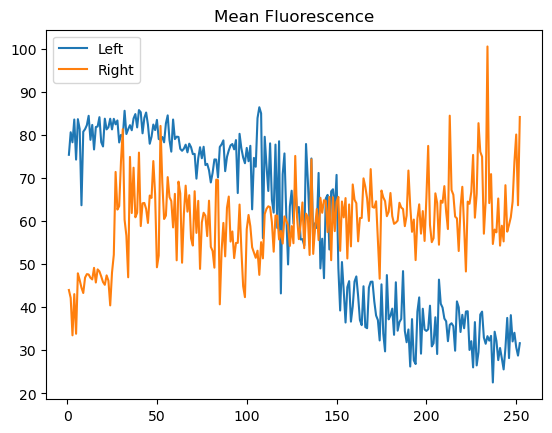

In [15]:
fig, ax = plt.subplots(1, sharex=True)

left_edge_data = data_df[data_df["Edge"] == "L"]
right_edge_data = data_df[data_df["Edge"] == "R"]

X = left_edge_data["Frame"]

Y3 = left_edge_data["Mean Intensity"]
Y4 = right_edge_data["Mean Intensity"]

ax.plot(X, Y3)
ax.plot(X, Y4)
ax.set_title("Mean Fluorescence")

ax.legend(["Left","Right"],loc='best') 
ax.legend(["Left","Right"],loc='best')

plt.savefig("movie5_fluorescence_line_plot.png")
plt.show()

## Cell Displacement over time

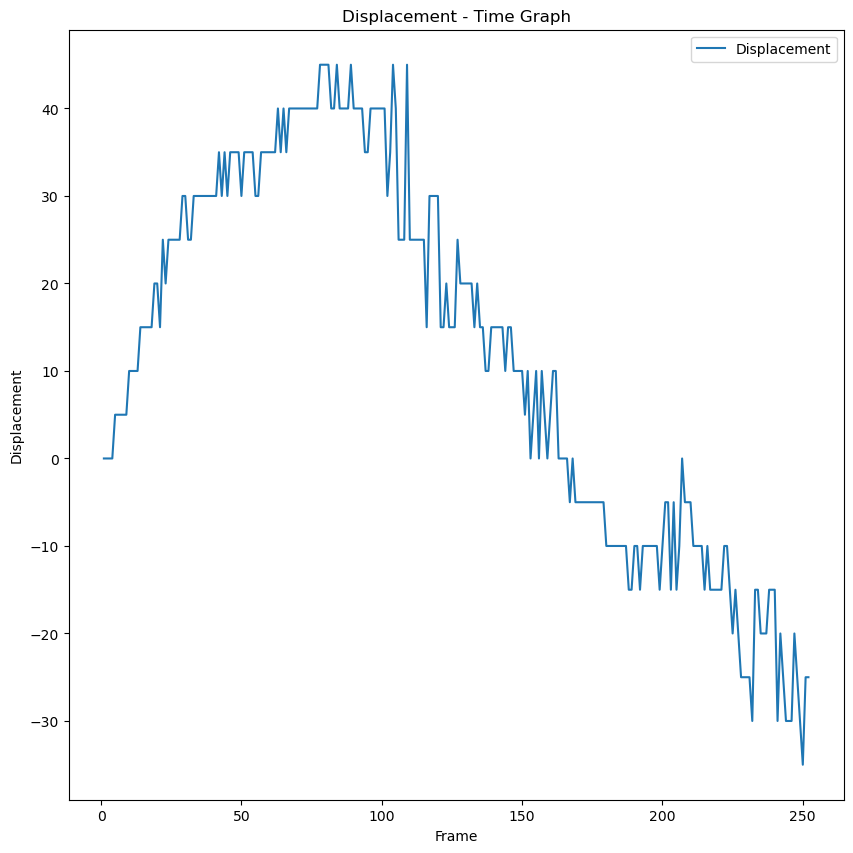

In [13]:
plt.figure(figsize=(10,10))
plt.plot(data_df.Frame, data_df["Displacement"], label="Displacement")

plt.title("Displacement - Time Graph")
plt.ylabel("Displacement")
plt.xlabel("Frame")
plt.legend()
#plt.xticks(data_df.Frame)
plt.savefig("movie5_displacement_plot.png")
plt.show()